## Read data

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from scipy.spatial import distance_matrix
import sklearn
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.mixture import GaussianMixture

## Data Engineering

- Only use the US regional data.
- Convert the date column to Datetime
- delete datapoints with null vaccination policy

In [2]:
data = pd.read_csv('OxCGRT_latest.csv')

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data_usa = data[data['CountryCode']=='USA']

#drop nationwide data
data_usa = data_usa.dropna(subset=['RegionName'])

#convert int date to datetime
data_usa['Datetime'] = pd.to_datetime(data_usa['Date'], format='%Y%m%d')

#only look at data between 2020-12-1 and 2021-6-1 (when policy change is happening)
data_usa = data_usa[(data_usa['Datetime']<pd.Timestamp(2021,6,1)) & (data_usa['Datetime']>pd.Timestamp(2020,12,1))]

In [4]:
data_vacpol_usa = data_usa[['RegionName', 'H7_Vaccination policy', 'Datetime']]

In [5]:
# Create a new dataframe with states as features
df_states = data_vacpol_usa.pivot(index='RegionName', columns='Datetime')['H7_Vaccination policy']

#Drop any columns with at least one NaN
df_states = df_states.dropna(axis='columns')

In [6]:
df_states.head()

Datetime,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,...,2021-05-20,2021-05-21,2021-05-22,2021-05-23,2021-05-25,2021-05-26,2021-05-27,2021-05-28,2021-05-29,2021-05-30
RegionName,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Alaska,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Arizona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Arkansas,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
California,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


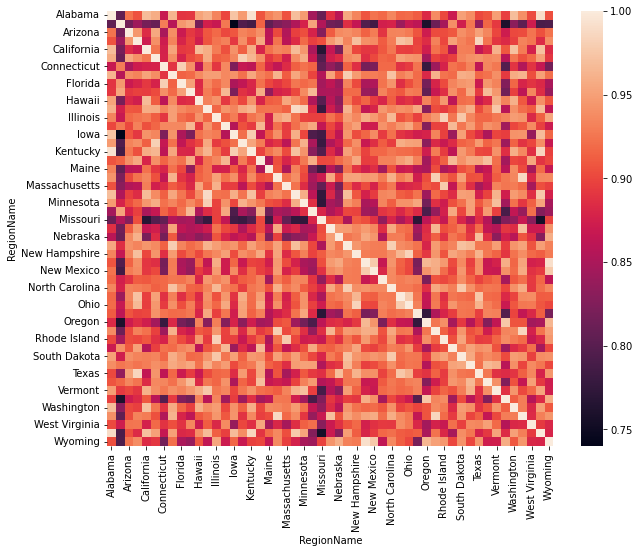

In [7]:
states_cols = df_states.transpose(copy = True)
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(states_cols.corr())
plt.show()

In [8]:
pca = sklearn.decomposition.PCA(n_components = 51)
dates_reduced = pca.fit_transform(df_states)
dates_reduced = pd.DataFrame(dates_reduced)

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/sklearn/utils/validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


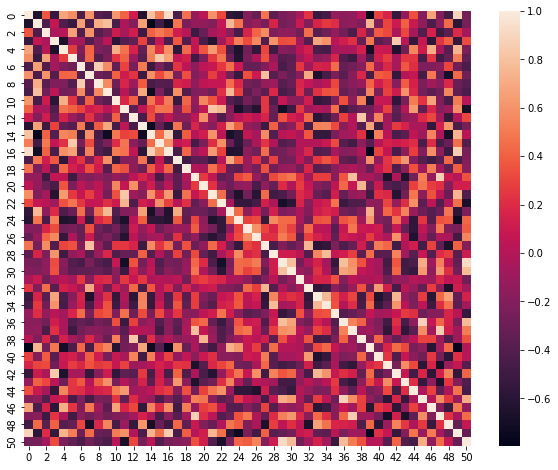

In [9]:
states_reduced_cols = dates_reduced.transpose(copy = True)
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(states_reduced_cols.corr())
plt.show()

In [10]:
kmeans = KMeans(n_clusters = 10)
classes = kmeans.fit_transform(dates_reduced)

In [11]:
sns.pairplot(pd.DataFrame(dates_reduced)

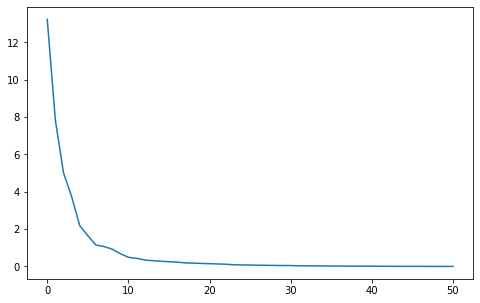

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
plt.plot(pca.explained_variance_)
plt.show()

## Create a distance matrix and 

l1 distance.

In [199]:
n_clusters = 4
gmm = GaussianMixture(n_components = n_clusters, covariance_type = 'tied')
gmm_labels =gmm.fit_predict(X)

dict_stategroups = dict(zip(states,gmm_labels))
print(dict_stategroups)
state_groups = [list(df_states.index[clustering.labels_== i]) for i in range(n_clusters)]

{'Alabama': 2, 'Alaska': 0, 'Arizona': 2, 'Arkansas': 1, 'California': 2, 'Colorado': 2, 'Connecticut': 0, 'Delaware': 2, 'Florida': 0, 'Georgia': 0, 'Hawaii': 2, 'Idaho': 2, 'Illinois': 3, 'Indiana': 0, 'Iowa': 2, 'Kansas': 2, 'Kentucky': 2, 'Louisiana': 0, 'Maine': 3, 'Maryland': 1, 'Massachusetts': 3, 'Michigan': 2, 'Minnesota': 2, 'Mississippi': 0, 'Missouri': 0, 'Montana': 1, 'Nebraska': 1, 'Nevada': 2, 'New Hampshire': 1, 'New Jersey': 1, 'New Mexico': 1, 'New York': 3, 'North Carolina': 3, 'North Dakota': 1, 'Ohio': 1, 'Oklahoma': 3, 'Oregon': 1, 'Pennsylvania': 1, 'Rhode Island': 3, 'South Carolina': 0, 'South Dakota': 3, 'Tennessee': 2, 'Texas': 1, 'Utah': 3, 'Vermont': 2, 'Virginia': 1, 'Washington': 2, 'Washington DC': 1, 'West Virginia': 1, 'Wisconsin': 2, 'Wyoming': 1}


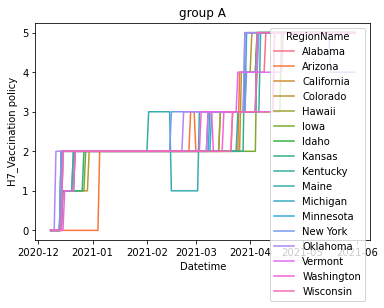

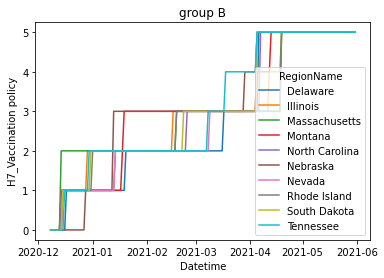

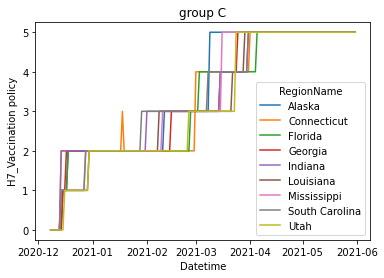

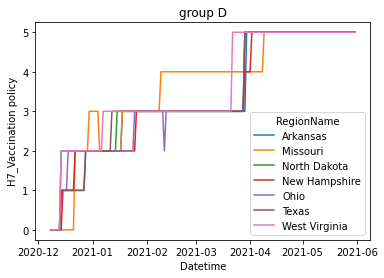

In [200]:
for i in range(n_clusters):
    data_onereg = data_usa[data_usa['RegionName'].isin(state_groups[i])]
    sns.lineplot(data=data_onereg, x='Datetime', y='H7_Vaccination policy', hue="RegionName")
    plt.title('group '+chr(i+65))
    plt.show()

In [ ]:
for i in range(n_clusters):
    

In [91]:
df = df_states
X = pd.DataFrame(distance_matrix(df.values, df.values, p=1), 
                 index=df.index, columns=df.index)

In [109]:
X.head()

RegionName,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,...,Tennessee,Texas,Utah,Vermont,Virginia,Washington,Washington DC,West Virginia,Wisconsin,Wyoming
RegionName,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,98.0,53.0,83.0,19.0,27.0,71.0,37.0,63.0,73.0,...,42.0,91.0,59.0,39.0,91.0,18.0,72.0,112.0,8.0,83.0
Alaska,98.0,0.0,123.0,77.0,95.0,99.0,55.0,125.0,49.0,27.0,...,74.0,81.0,57.0,79.0,103.0,92.0,84.0,66.0,96.0,103.0
Arizona,53.0,123.0,0.0,104.0,72.0,36.0,102.0,58.0,88.0,98.0,...,55.0,110.0,66.0,72.0,138.0,69.0,119.0,137.0,59.0,114.0
Arkansas,83.0,77.0,104.0,0.0,88.0,76.0,86.0,98.0,82.0,60.0,...,71.0,8.0,54.0,82.0,48.0,77.0,29.0,41.0,89.0,28.0
California,19.0,95.0,72.0,88.0,0.0,46.0,62.0,44.0,60.0,68.0,...,47.0,96.0,64.0,26.0,72.0,17.0,61.0,103.0,13.0,84.0


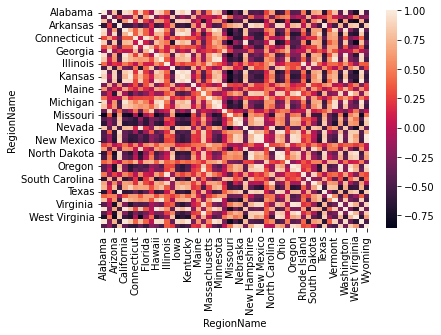

In [107]:
corr_dist = X.corr()
sns.heatmap(corr_dist)
plt.show()
corr_dist = X.corr()
sns.heatmap(corr_dist)
plt.show()

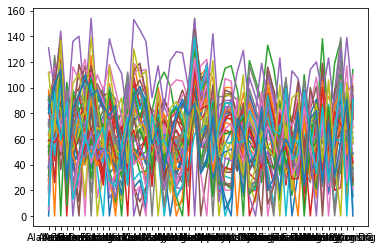

In [100]:
plt.plot(X)
plt.show()

In [103]:
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(df_states)

states = df_states.index

#create a dictionary which maps states to group number
# ex) 'Alabama':1
dict_stategroups = dict(zip(states,clustering.labels_ ))
print(dict_stategroups)

#OR if you want a state code ('AL') to be a key...
# from states_dictionary import us_state_to_code

# dict_code2groups = dict()
# dict_to_code = us_state_to_code()

# for state in states:
#     code = dict_to_code[state]
#     dict_code2groups[code] = dict_stategroups[state]
# print(dict_code2groups)

{'Alabama': 0, 'Alaska': 2, 'Arizona': 0, 'Arkansas': 3, 'California': 0, 'Colorado': 0, 'Connecticut': 2, 'Delaware': 1, 'Florida': 2, 'Georgia': 2, 'Hawaii': 0, 'Idaho': 0, 'Illinois': 1, 'Indiana': 2, 'Iowa': 0, 'Kansas': 0, 'Kentucky': 0, 'Louisiana': 2, 'Maine': 0, 'Maryland': 4, 'Massachusetts': 1, 'Michigan': 0, 'Minnesota': 0, 'Mississippi': 2, 'Missouri': 3, 'Montana': 1, 'Nebraska': 1, 'Nevada': 1, 'New Hampshire': 3, 'New Jersey': 4, 'New Mexico': 4, 'New York': 0, 'North Carolina': 1, 'North Dakota': 3, 'Ohio': 3, 'Oklahoma': 0, 'Oregon': 4, 'Pennsylvania': 4, 'Rhode Island': 1, 'South Carolina': 2, 'South Dakota': 1, 'Tennessee': 1, 'Texas': 3, 'Utah': 2, 'Vermont': 0, 'Virginia': 4, 'Washington': 0, 'Washington DC': 4, 'West Virginia': 3, 'Wisconsin': 0, 'Wyoming': 4}


In [104]:
#show groups

state_groups = [list(df_states.index[clustering.labels_== i]) for i in range(n_clusters)]

# for i in range(n_clusters):
#     print('group ', chr(i+65),':', state_groups[i])

Compare vaccination policy for each group

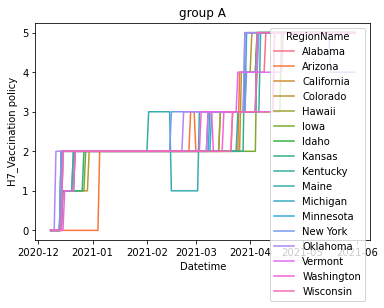

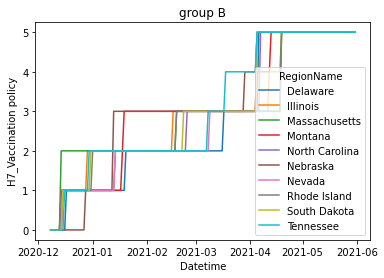

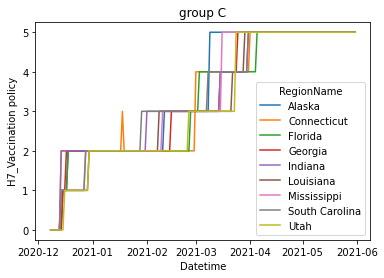

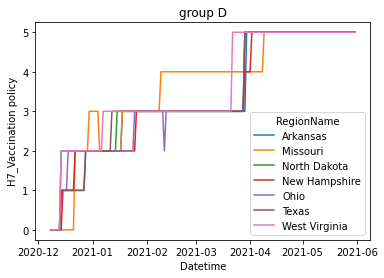

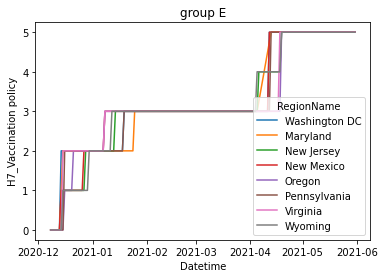

In [105]:
for i in range(n_clusters):
    data_onereg = data_usa[data_usa['RegionName'].isin(state_groups[i])]
    sns.lineplot(data=data_onereg, x='Datetime', y='H7_Vaccination policy', hue="RegionName")
    plt.title('group '+chr(i+65))
    plt.show()

In [201]:
from tslearn.clustering import TimeSeriesKMeans

In [202]:
n_clusters = 4
tskmeans = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'dtw', n_init = 5)

In [203]:
labels_tsk = tskmeans.fit_predict(df_states)

In [204]:
dict_stategroups = dict(zip(states,labels_tsk))
print(dict_stategroups)

{'Alabama': 2, 'Alaska': 3, 'Arizona': 0, 'Arkansas': 3, 'California': 1, 'Colorado': 0, 'Connecticut': 0, 'Delaware': 3, 'Florida': 2, 'Georgia': 2, 'Hawaii': 3, 'Idaho': 1, 'Illinois': 2, 'Indiana': 1, 'Iowa': 0, 'Kansas': 0, 'Kentucky': 3, 'Louisiana': 2, 'Maine': 3, 'Maryland': 3, 'Massachusetts': 1, 'Michigan': 1, 'Minnesota': 1, 'Mississippi': 3, 'Missouri': 1, 'Montana': 2, 'Nebraska': 2, 'Nevada': 3, 'New Hampshire': 2, 'New Jersey': 2, 'New Mexico': 3, 'New York': 1, 'North Carolina': 3, 'North Dakota': 1, 'Ohio': 3, 'Oklahoma': 1, 'Oregon': 3, 'Pennsylvania': 1, 'Rhode Island': 3, 'South Carolina': 2, 'South Dakota': 3, 'Tennessee': 2, 'Texas': 3, 'Utah': 3, 'Vermont': 1, 'Virginia': 1, 'Washington': 3, 'Washington DC': 1, 'West Virginia': 1, 'Wisconsin': 1, 'Wyoming': 2}


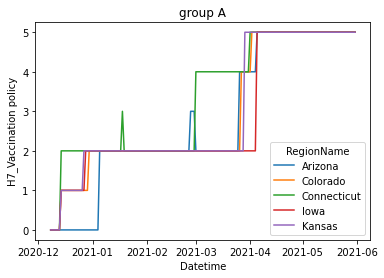

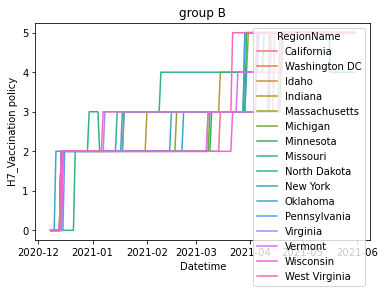

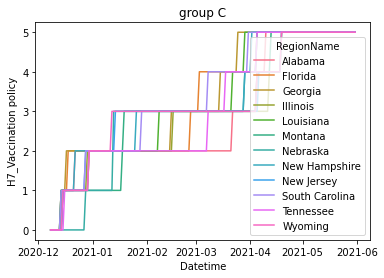

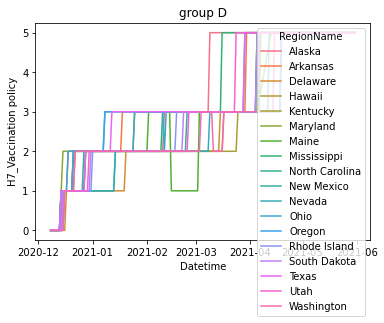

In [205]:
states = df_states.index
state_groups = [list(df_states.index[labels_tsk== i]) for i in range(n_clusters+1)]

for i in range(n_clusters):
    data_onereg = data_usa[data_usa['RegionName'].isin(state_groups[i])]
    sns.lineplot(data=data_onereg, x='Datetime', y='H7_Vaccination policy', hue="RegionName")
    plt.title('group '+chr(i+65))
    plt.show()